# Vertical, viscous deflection of a thin plate

In parallel with the [elastic deflection notebook](https://github.com/chrismiele/weird_flex/blob/main/flexure/kirchhoff_plate_elastic.ipynb), the goal of this notebook is to treat an ice shelf as a rectangular thin plate, load it with a spatially uniform surface mass balance, and calculate the rate of vertical, viscous deflection that results from buoyancy "correcting" the surface elevation change. This notebook references a 2007 text by Dietrich Braess, [online lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf) by Jarkko Niiranen, and [MacAyeal et al., 2021](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3). I sketch the derivation of the weak form of the viscous deflection problem, solve the weak form using Firedrake, and verify that the solution preserves the original force balance constraint. At the end, I incorporate a simple fracture law for surface and basal crevasses.

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors 

# Deriving the variational form to be solved

## Strong form (force balance)

The stress balance for a thin plate states that the bending moment $\vec{M}$ relates to the load on the plate via

$$-\nabla\cdot\left(\nabla\cdot\vec{M}\right) = f(x, y).$$

## Constitutive relation

The constitutive relation must relate $\vec{M}$ to the rate of vertical deflection, $\dot{\eta}$. I use the constitutive relation from MacAyeal et al. 2021 (Eq. 32), which states that, with $\overline{\nu}$ the depth-averaged effective viscosity associated with the flow field (which is independent of $\dot{\eta}$), 

$$\vec{M} = -\frac{\overline{\nu}H^3}{6}\left(\nabla^2\dot{\eta} + tr\left(\nabla^2\dot{\eta}\right)\vec{I}\right) + \rho_ig\frac{H^3}{12}\vec{I}.$$

In general, it will be necessary to obtain $\overline{\nu}$ via the velocity field. For now, we'll assume linear rheology, so that $\overline{\nu}$ is just a constant:

In [2]:
from icepack.constants import year #number of seconds per year
ν = 5e15/year #representative uniform viscosity in Pascal*years

We can simplify this constitutive relation further by omitting the glaciostatic term (the final term on the right), as in MacAyeal et al. The second derivative of this term relates to convexity/concavity of the shelf, and it is expected to usually be small. In situations where this may not be the case, the glaciostatic term can be included in the load term defined later. Thus, for now, we use the constitutive relation:

$$\vec{M} = -\frac{\overline{\nu}H^3}{6}\left(\nabla^2\dot{\eta} + tr\left(\nabla^2\dot{\eta}\right)\vec{I}\right).$$




## Weak form

To obtain the weak form, multiply both sides of the governing equation by an arbitrary weight function $w(x, y)$, and integrate over the domain, so that

$$ -\int_{x, y}\nabla\cdot(\nabla\cdot\vec{M})w(x, y)dxdy = \int_{x, y}f(x, y)w(x, y)dxdy.$$

Integrate by parts twice, following pg. 93 of Jarkko Niiranen's [lecture notes](https://mycourses.aalto.fi/pluginfile.php/896791/mod_resource/content/3/CIV-E4090-2019-Lectures2.pdf), to find that

$$-\int_{x, y}\vec{M}:\nabla^2w(x, y)dxdy = \int_{x, y}f(x, y)w(x, y)dxdy,$$

where I have left out the boundary terms (since we'll just use the penalty method to include any desired boundary conditions anyway). Use the above constitutive relation, noting that $tr(\nabla^2\dot{\eta})\vec{I}:\nabla^2w = \Delta\dot{\eta}\Delta w$, to obtain the weak form of the problem:

$$\frac{1}{6}\int_{x, y}\overline{\nu}H^3\nabla^2\dot{\eta} : \nabla^2wdxdy + \frac{1}{6}\int_{x, y}\overline{\nu}H^3\Delta\dot{\eta}\Delta w dxdy - \int_{x, y}f(x, y)w(x, y)dxdy = 0.$$

# Solving the problem with Firedrake

## Spatial extent and mesh

In [3]:
nx, ny = 200, 100
Lx, Ly = 10000, 5000 #10 km long by 5 km wide shelf
mesh = RectangleMesh(nx, ny, Lx, Ly)

x, y = SpatialCoordinate(mesh)
Q = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements of order 5 are needed to solve this 4th-order problem

## Physical parameters

In [4]:
ρ_i = 917 #ice density in kg/m^3
ρ_w = 1024 #saltwater density in kg/m^3
g = 9.81 #g in N/kg
H = 600 #initial shelf thickness in meters

## Trial and test functions, and their gradients

In [5]:
#trial function η and its gradients
η = Function(Q) #the deflection rate to be solved for
ddη = grad(grad(η)) #∇^2(η)
Δη = div(grad(η)) #the laplacian of η

#test function and its gradients
w = TestFunction(Q) 
ddw = grad(grad(w))
Δw = div(grad(w)) #the laplacian of w

## Load on the shelf

I'll load the shelf by imposing a spatially uniform surface mass balance, $\dot{a}\Delta t$, where $\dot{a}$ is the accumulation/ablation rate, and $\Delta t$ is some timestep. The load from this surface mass balance is fundamentally driven by the resulting height above (or below) buoyancy, $h_{ab}$. If $h_{ab} < 0$, the force on the shelf acts upward and attains value $f = -\rho_wgh_{ab}$. Conversely, if $h_{ab} > 0$, the force on the shelf acts downward and attains value $f = -\rho_igh_{ab}$. Therefore, the appropriate load on the shelf due to surface mass balance is

$$f = \begin{cases} -\rho_wgh_{ab} & h_{ab} \leq 0\\
-\rho_igh_{ab} & h_{ab} > 0. \end{cases}$$

Height above buoyancy can be calculated as follows:

 - At time $t = 0$, the initial surface elevation is $s_0 = \left(1 - \frac{\rho_i}{\rho_w}\right)H_0$
 - After time $\Delta t$, the surface elevation becomes $s = \left(1 - \frac{\rho_i}{\rho_w}\right)H_0 + \dot{a}\Delta t + \dot{\eta}\Delta t$
 - Noting that deflections do not influence thickness, the updated thickness after $\Delta t$ becomes $H = H_0 + \dot{a}\Delta t$
 - Given the updated thickness, the equilibrium surface elevation would now be $s_{eq} = \left(1 - \frac{\rho_i}{\rho_w}\right)(H_0 + \dot{a}\Delta t)$
 - Therefore, height above/below buoyancy is $h_{ab} = s - s_{eq} = \frac{\rho_i}{\rho_w}\dot{a}\Delta t + \dot{\eta}\Delta t$.

In [6]:
Δt = 1/10 #timestep in years
a = -1 #ablation rate in meters per year
h_ab = ρ_i/ρ_w*a*Δt + η*Δt #height above buoyancy after one timestep
f = conditional(h_ab <= 0, -ρ_w*g*h_ab, -ρ_i*g*h_ab)

## Set up the problem to be solved

Solving the weak form is equivalent to minimizing the expression:

$$\Pi(\eta, v) = \frac{1}{6}\int_{x, y}\overline{\nu}H^3\nabla^2\dot{\eta} : \nabla^2 vdxdy + \frac{1}{6}\int_{x, y}\overline{\nu}H^3\Delta\dot{\eta}\Delta v dxdy + \int_{x, y}f(x, y)v(x, y)dxdy$$

subject to some boundary conditions. I'll impose no-slip boundary conditions at the sidewalls and the upstream boundary, so that $\dot{\eta} = 0$ on boundaries 1, 3 and 4. Constraints will be enforced via the penalty method. 

In [7]:
L = 1/6*ν*H**3*inner(ddη, ddw)*dx
L += 1/6*ν*H**3*Δη*Δw*dx
L -= f*w*dx

α = 1e10 #arbitrarily chosen, large penalty parameter
L += 0.5*α**2*η*w*ds(1) #deflection rate = 0 on upstream boundary
L += 0.5*α**2*η*w*ds(3) #left boundary
L += 0.5*α**2*η*w*ds(4) #right boundary

## Solve and plot

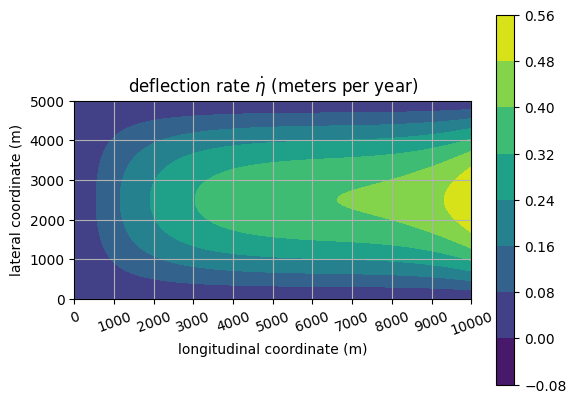

In [8]:
solve(L == 0, η)

fig, ax = plt.subplots()
ax.set_aspect('equal')
def_plot = tricontourf(project(η, Q), axes = ax)
plt.colorbar(def_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('deflection rate $\dot{η}$ (meters per year)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Verify that the solution satisfies the force balance

If everything went right, we should have that $\nabla\cdot\left(\nabla\cdot\vec{M}(\dot{\eta})\right) + f(x, y) = 0$. As shown below, there is some noise near the corners, but the noise does seem to get smaller and smaller as the mesh is refined, without significantly impacting the solution. 

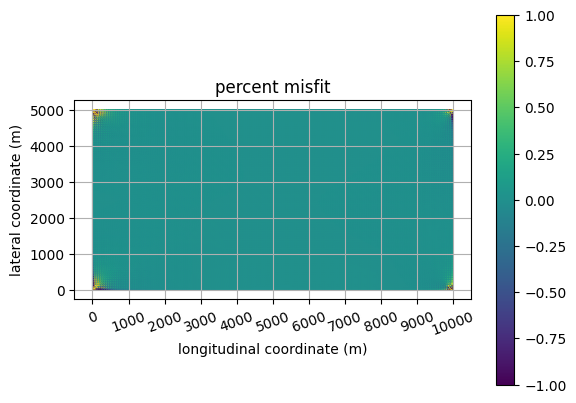

In [9]:
M = -ν*H**3/6*(ddη + tr(ddη)*Identity(2)) #the tensor M, as obtained earlier
misfit = project((div(div(M)) + f)/f*100, Q) #should ideally be very small

fig, ax = plt.subplots()
ax.set_aspect('equal')
diff_plot = tripcolor(misfit, axes = ax, vmin = -1, vmax = 1)
plt.colorbar(diff_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation=20)
plt.title('percent misfit')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

# Incorporating fracture

## Surface crevasses

In the absence of flow, the stress field arising from the above treatment of viscous flexure is

$$\tau = -2\nu\nabla^2\dot{\eta}\zeta.$$

We use the Nye zero-stress criterion to estimate surface crevasse depth in the plate (we discuss basal crevasses below). The zero-stress criterion states that crevasses penetrate to the depth $d$ at which the overburden overtakes the first principal tension, $\tau_1$, which occurs when

$$\tau_1 = \rho_igd.$$

Let $\zeta_c$ represent the vertical coordinate at depth $d$ (i.e., $\zeta_c := \frac{H}{2} - d)$. Without loss of generality, we may assume that $\zeta_c$ is positive: at the shelf 's vertical midpoint ($\zeta = 0$), the stress tensor is uniformly zero, and, hence, the overburden must already have surpassed the principal tension at this depth. Let $\lambda_1$ indicate the first eigenvalue of $-2\nu\nabla^2\dot{\eta}$. Since $\zeta_c \geq 0$, we have that $\tau_1 = \lambda_1\zeta_c = \lambda_1\left(\frac{H}{2} - d\right)$, and we can rewrite the equation above to become

$$\lambda_1\frac{H}{2} - \lambda_1d = \rho_igd.$$

Crevasse depth can now be calculated as

$$d = \frac{\lambda_1}{2(\rho_ig + \lambda_1)}H$$

wherever this value falls within $[0, \frac{H}{2}]$ (We may get nonsensical values outside this range if the surface is not in tension.)

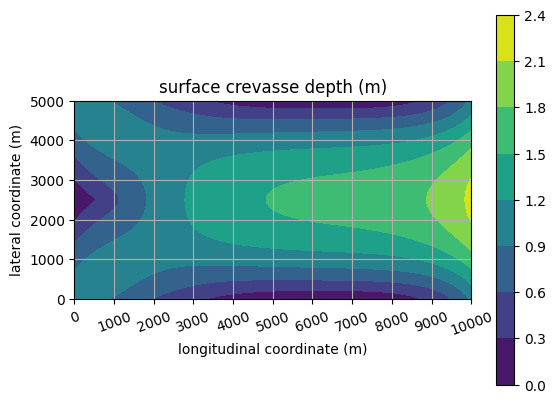

In [10]:
from icepack.utilities import eigenvalues

λ_1 = Function(Q).project(eigenvalues(-2*ν*ddη)[0])
d = λ_1*H/(2*(ρ_i*g + λ_1))
d = conditional(d >= 0, d, 0) #exclude any negative values
d = conditional(d <= H/2, d, 0)
d = project(d, Q)

fig, ax = plt.subplots()
ax.set_aspect('equal')
stress_plot = tricontourf(d, axes = ax)
plt.colorbar(stress_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('surface crevasse depth (m)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()

## Basal crevasses

For a shelf in flexure, it may sometimes be the case that the principal tension at the base is greater than the overburden, which would permit the formation of a basal crevasse under the Nye theory. Like surface crevasses, the maximum vertical extent of a basal crevasse is the shelf midpoint: moving upward through the ice column, the stress state reaches zero at $\zeta = 0$, while the overburden is nonzero until the surface, and so the principal tension will be overtaken by the overburden at some point before the vertical midpoint of the shelf. In this case, the vertical coordinate to which a basal crevasse penetrates, $\zeta_c$, will always be negative. Therefore, with $\lambda_2$ the *second* eigenvalue of $-2\nu\nabla^2\dot{\eta}$, we will have that $\tau_1 = \lambda_2\zeta_c$. 

In order to calculate crevasse depth as upward penetration from the base, we may characterize the crevasse depth so that $\zeta_c =: d - \frac{H}{2}$ (e.g., if a crevasse were to penetrate all the way up to the shelf midpoint, so that $\zeta_c = 0$, this crevasse would have depth $\frac{H}{2}$, or one-half the shelf thickness). By this characterization, the zero-stress criterion would require that $d$ satisfy $\tau_1 = \rho_ig(H - d)$, and it follows that

$$\lambda_2d - \lambda_2\frac{H}{2} = \rho_igH - \rho_igd.$$

Therefore, the crevasse depth (measured upward from the base) is calculated as

$$d = \frac{\frac{1}{2}\lambda_2 + \rho_ig}{\lambda_2 + \rho_ig}H$$

wherever this value falls within $[0, \frac{H}{2}]$ (i.e., when the base is in tension greater than the overburden pressure). In the case shown below, there are no basal crevasses because the principal tension at the base is far outweighed by the overburden. 

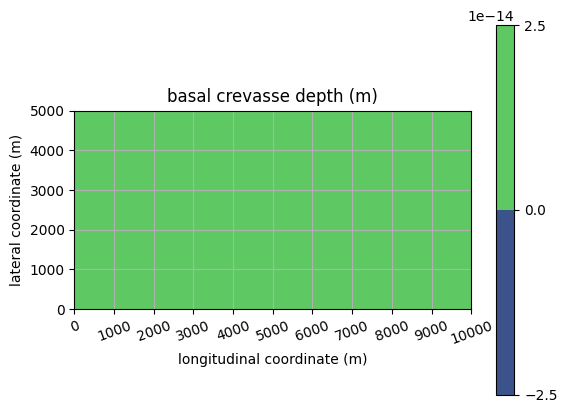

In [11]:
λ_2 = Function(Q).project(eigenvalues(-2*ν*ddη)[1])
d = (1/2*λ_2 + ρ_i*g)/(λ_2 + ρ_i*g)*H
d = conditional(d >= 0, d, 0) 
d = conditional(d <= H/2, d, 0) 
d = project(d, Q)

fig, ax = plt.subplots()
ax.set_aspect('equal')
stress_plot = tricontourf(d, axes = ax)
plt.colorbar(stress_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('basal crevasse depth (m)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')
plt.grid()